## **Описание задачи**

Необходимо провести исследование и написать код, который будет оценивать степень влияния признаков на целевую метрику. В нашем случае, целевая метрика - CTR (кликабельность объявления - чем выше, тем лучше). 

Грубо говоря, вам нужно придумать (или использовать какой-то готовый) алгоритм(-ы), которые покажут - насколько при изменении значении каждого признака меняется значение целевой метрики. 

По итогу, на основании ваших расчетов, мы должны автоматически строить примерно такой график:

![](\images\Example_graph.png)

Здесь мы видим, что при изменении объектов CTR меняется довольно сильно, при изменении главного цвета - тоже довольно сильно, также и при изменении длины текста. Чуть меньше CTR зависит от вспомогательных цветов. Остальные признаки слабо влияют на изменение CTR. 

На данном графике % - некая условная величина, которую мы для себя вывели, она показывает степень влияния того или иного признака на целевую метрику. Сумма всех процентов не обязана равняться 100%.

**Таким образом, задача сводится к построению модели регрессионного анализа, предсказывающей изменение количества кликов при изменении того или иного параметра рекламного объявления, с последующей визуализации этой зависимости (динамический дашборд, показывающий важность каждого из признаков для целевой переменной)**

## Описание признаков

- **признаки**

adtext_text - текст в теле объявления

adtext_language - язык исходного текста в теле объявления

adtext_eng - перевод текста на англ

adtext_length - длина текста

adtext_nouns - существительные в тексте

adtext_verbs - глаголы в тексте

adtext_adjs - прилагательные

adtext_contains_cta - содержит ли текст призыв к действию (call to action)

adtext_contains_question - содержит ли текст вопрос 

… - далее идет тоже самое для description (описание объялвения) и headline (заголовок объявления)

cta_type - тип кнопки на объявлении

image_text_present - есть ли на картинке текст

image_text - текст на картинке

image_eng_text - англ перевод текста

image_text_area - объем текста

image_text_length - длина текста

image_language - язык текста

image_text_contains_question - содержит вопрос?

image_text_contains_cta - содерит CTA? 

image_nouns - сущ (массив)

image_verbs - глаголы (массив)

image_adjs - прилаг (массив)

image_phrases - отдельные фразы (массив)

image_color_main - главный цвет

image_color_rest - дополнительные цвета  (массив)

image_proportions - пропорции картинки

image_objects - объекты  (массив)

image_tags - дополнительные объекты  (массив)

image_people_amount - кол-во людей на картинке

image_clip - не берите этот признак в расчет

image_clip_keywords - не берите этот признак в расчет

- **целевая переменная**

ctr - значение метрики CTR

## ПРИМЕР ТАГГИРОВАНИЯ

![](images\tagging_example.jpg)

In [1693]:
# Формируем среду`
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt

import category_encoders as ce

from scipy.stats import normaltest

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import warnings 
warnings.filterwarnings("ignore")

In [1542]:
# фиксируем RANDOM_SEED для воспроизводимоcти эксперимента
RANDOM_STATE = 42

## Получение и обзор данных

In [1543]:
df = pd.read_excel('data/tagging.xlsx')
df.head()

,adtext_text,adtext_language,adtext_eng,adtext_length,adtext_nouns,adtext_verbs,adtext_adjs,adtext_contains_cta,adtext_contains_question,headline_text,...,image_phrases,image_color_main,image_color_rest,image_proportions,image_objects,image_tags,image_people_amount,image_clip,image_clip_keywords,ctr
0,«This app contains everything that I wanted to...,en,This app contains everything that I wanted to ...,200,"['kind', 'moon', 'spirituality', 'lot', 'calen...","['enjoy', 'introducing', 'wanted', 'contains',...","['favorite', 'different']",False,False,Magic in your pocket ✨👉,...,"['hot apple cider', 'collect acorns', 'and nut...",#ccffff,['#6666cc'],2048x2048,['tableware'],"['poster', 'illustration', 'font', 'product', ...",1,a mulato man with a notebook sitting at the ta...,"['word1', 'word2', 'word3']",0.007162
1,"✨ Follow Moon phases, receive positive affirma...",en,Follow Moon phases receive positive affirmati...,100,"['moon', 'runes', 'affirmations', 'phases', 'a...","['follow', 'learn', 'receive']","['positive', 'moonly']",False,False,Try Moon Calendar 👉,...,"['regret', 'anxiety', 'you', 'action', 'change...",#666666,"['#333333', '#663333', '#999999', '#333300']",2048x2048,[],"['electric blue', 'landscape', 'font', 'slope'...",1,a mulato man with a notebook sitting at the ta...,"['word1', 'word2', 'word3']",0.005659
2,"✨ Follow Moon phases, receive positive affirma...",en,Follow Moon phases receive positive affirmati...,100,"['moon', 'runes', 'affirmations', 'phases', 'a...","['follow', 'learn', 'receive']","['positive', 'moonly']",False,False,Try Moon Calendar 👉,...,"['regret', 'anxiety', 'you', 'action', 'change...",#666666,"['#333333', '#663333', '#999999', '#333300']",2048x2048,[],"['electric blue', 'landscape', 'font', 'slope'...",1,a mulato man with a notebook sitting at the ta...,"['word1', 'word2', 'word3']",0.005659
3,«This app contains everything that I wanted to...,en,This app contains everything that I wanted to ...,200,"['kind', 'moon', 'spirituality', 'lot', 'calen...","['enjoy', 'introducing', 'wanted', 'contains',...","['favorite', 'different']",False,False,Magic in your pocket ✨👉,...,"['guide for little witches', 'n', 'moon calend...",#996633,"['#663333', '#666666', '#996666', '#333333']",1280x1280,['packaged goods'],"['carnivore', 'electric blue', 'small to mediu...",1,a mulato man with a notebook sitting at the ta...,"['word1', 'word2', 'word3']",0.007388
4,«This app contains everything that I wanted to...,en,This app contains everything that I wanted to ...,200,"['kind', 'moon', 'spirituality', 'lot', 'calen...","['enjoy', 'introducing', 'wanted', 'contains',...","['favorite', 'different']",False,False,Magic in your pocket ✨👉,...,"['guide for little witches', 'n', 'moon calend...",#996633,"['#663333', '#666666', '#996666', '#333333']",1280x1280,['packaged goods'],"['carnivore', 'electric blue', 'small to mediu...",1,a mulato man with a notebook sitting at the ta...,"['word1', 'word2', 'word3']",0.006329


In [1544]:
df[df.columns[28:]].isna().sum()

image_text_present              0
image_text                      0
image_eng_text                  0
image_text_area                 0
image_text_length               0
image_language                  0
image_text_contains_question    0
image_text_contains_cta         0
image_nouns                     0
image_verbs                     0
image_adjs                      0
image_phrases                   0
image_color_main                0
image_color_rest                0
image_proportions               0
image_objects                   0
image_tags                      0
image_people_amount             0
image_clip                      0
image_clip_keywords             0
ctr                             0
dtype: int64

Правильно подобранные слова текста объявления (заголовков, тела, описания), конечно, должны сильно мотивировать клиента на клик по нему, но в данном проект ограничимся влиянием графических решений рекламы, кроме того в признаках текста достаточно много пропусков, поэтому оставим в данных только те столбцы, которые отвечают за картинку объявления

In [1545]:
# Избавляемся от ненужных признаков и выводим информацию о датасете
df = df[df.columns[28:]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   image_text_present            399 non-null    bool   
 1   image_text                    399 non-null    object 
 2   image_eng_text                399 non-null    object 
 3   image_text_area               399 non-null    int64  
 4   image_text_length             399 non-null    int64  
 5   image_language                399 non-null    object 
 6   image_text_contains_question  399 non-null    bool   
 7   image_text_contains_cta       399 non-null    bool   
 8   image_nouns                   399 non-null    object 
 9   image_verbs                   399 non-null    object 
 10  image_adjs                    399 non-null    object 
 11  image_phrases                 399 non-null    object 
 12  image_color_main              399 non-null    object 
 13  image

В датасете 20 признаков, 14 из которых категориальные, 3 - числовые и 3 - булевые, 1 целевая переменнам (ctr), а также 399 наблюдений

## Анализ и обработка данных

In [1546]:
# Проверка на пропуски
df.isnull().sum().sum()

0

**Вывод**
Пропуски в данных отсуствуют

### Анализ признаков

In [1547]:
# Числовые признаки (без целевой переменныой - последний столбец)
df.iloc[:, :-1].describe()[1:].T

,mean,std,min,25%,50%,75%,max
image_text_area,11.829574,4.529194,0.0,10.0,10.0,10.0,30.0
image_text_length,172.994987,125.197291,25.0,100.0,150.0,200.0,800.0
image_people_amount,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [1548]:
# Булевы признаки
df.describe(include='bool')[1:].T

,unique,top,freq
image_text_present,1,True,399
image_text_contains_question,1,False,399
image_text_contains_cta,2,False,364


In [1549]:
# Категориальные признаки
df.describe(include='object')[1:].T

,unique,top,freq
image_text,73,Guide for little witches\nn\nMoon Calendar\nRu...,69
image_eng_text,73,Guide for little witches\nn\nMoon Calendar\nRu...,69
image_language,2,en,394
image_nouns,60,"['holidays', 'moon', 'sounds', 'calendar', 'wi...",86
image_verbs,54,[],119
image_adjs,43,"['runic', 'little', 'magical', 'ancient']",114
image_phrases,73,"['guide for little witches', 'n', 'moon calend...",69
image_color_main,26,#333333,168
image_color_rest,70,"['#663333', '#666666', '#996666', '#333333']",83
image_proportions,10,2048x2048,257


In [1550]:
df[['image_language', 'image_text_contains_cta']].value_counts(normalize=True)

image_language  image_text_contains_cta
en              False                      0.907268
                True                       0.080201
fr              True                       0.007519
                False                      0.005013
Name: proportion, dtype: float64

In [1551]:
df_dup = df[df.duplicated()]
print(df_dup.count())

image_text_present              60
image_text                      60
image_eng_text                  60
image_text_area                 60
image_text_length               60
image_language                  60
image_text_contains_question    60
image_text_contains_cta         60
image_nouns                     60
image_verbs                     60
image_adjs                      60
image_phrases                   60
image_color_main                60
image_color_rest                60
image_proportions               60
image_objects                   60
image_tags                      60
image_people_amount             60
image_clip                      60
image_clip_keywords             60
ctr                             60
dtype: int64


**Выводы**

1. Признаки `image_people_amount`, `image_clip`, `image_clip_keywords`, `image_text_present`, `image_text_contains_question` имеют только по одному значению, поэтому никак не влияют на целевую переменную и могут быть удалены
2. Признаки `image_language`, `image_text_contains_cta` содержит по два значения, но одно из них сильно превалирует (более 90% наблюдений), поэтому необходимо проверить их влияние на целевую переменную и если оно незначительно, удалить их
4. 60 наблюдений - это дубликаты, которые также подлежат удалению
5. Значение признаков `image_nouns`, `image_verbs`, `image_adjs`, `image_phrases`, `image_color_rest`, `image_objects`, `image_tags` представляют собой завёрнутые в строку списки (масссивы) значений, в том числе и пустые, которые требуют преобразования
6. В признаке `image_text_area` всего четыре уникальных знаыения, одно из которых (максимальное) встречается однажды, а следовательно с таким наблюдением тоже можно растаться, признав его выбросом, а сам признак может быть закодироован 



### Анализ целевой переменной

In [1552]:
#Построим распределение таргета
fig = px.histogram(df,
                   x='ctr',
                   marginal="box",
                   title='Распределение кликабельности (CTR)'
                   )
fig.show();

**Выводы**
1. Распределение таргета довольно близкое к нормальному, но требует дополнительной проверки
2. И гистограмма, и ящик показывают достаточно существенные выбросы

Разберёмся с языком (признак `image_language`)

In [1553]:
df.image_language.value_counts()

image_language
en    394
fr      5
Name: count, dtype: int64

In [1554]:
df[df.image_language == 'fr'][['image_nouns',
                                'image_verbs',
                                'image_adjs',
                                'image_text',
                                'image_eng_text',
                                'image_text_area',
                                'image_phrases',
                                'image_tags'
                                ]
]

,image_nouns,image_verbs,image_adjs,image_text,image_eng_text,image_text_area,image_phrases,image_tags
5,[],['become'],['happy'],Become\nyour happiest,Become\nyour happy,10,"['become', 'your happiest']","['cg artwork', 'magenta', 'purple', 'font', 'c..."
154,[],['become'],['happiest'],Become your\nhappiest,Become your\nhappiest,10,"['become your', 'happiest']","['happy', 'magenta', 'font', 'fictional charac..."
188,[],['become'],['happy'],Become\nyour happiest,Become\nyour happy,10,"['become', 'your happiest']","['illustration', 'happy', 'purple', 'font', 'm..."
255,['excuses'],"['ruin', 'let']",[],If you let excuses to ruin,If you let excuses to ruin,0,['if you let excuses to ruin'],"['eye', 'art', 'cartoon', 'doll', 'eyebrow', '..."
256,['excuses'],"['ruin', 'let']",[],If you let excuses to ruin,If you let excuses to ruin,0,['if you let excuses to ruin'],"['eye', 'art', 'cartoon', 'doll', 'eyebrow', '..."


Признак француского языка (`fr`) не оказывает влияния на другие признаки (значание в этих наблюдениях представлены на английском языке), поэтому признак языка (`image_language`) также не оказывает никакого влияния на таргет и может быть удалён

#### Избавляемся от неинформативных признаков

In [1555]:
drop_col = ['image_people_amount',
            'image_clip',
            'image_clip_keywords',
            'image_text_present',
            'image_text_contains_question',
            'image_language']
df_drop = df.drop(df[drop_col], axis=1)


#### Удаляем дубликаты

In [1556]:
df_drop = df_drop.drop_duplicates()
df_drop.reset_index(inplace=True, drop=True)

In [1557]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   image_text               339 non-null    object 
 1   image_eng_text           339 non-null    object 
 2   image_text_area          339 non-null    int64  
 3   image_text_length        339 non-null    int64  
 4   image_text_contains_cta  339 non-null    bool   
 5   image_nouns              339 non-null    object 
 6   image_verbs              339 non-null    object 
 7   image_adjs               339 non-null    object 
 8   image_phrases            339 non-null    object 
 9   image_color_main         339 non-null    object 
 10  image_color_rest         339 non-null    object 
 11  image_proportions        339 non-null    object 
 12  image_objects            339 non-null    object 
 13  image_tags               339 non-null    object 
 14  ctr                      3

In [1558]:
# Преобразуме строки в списки
def get_list(ser):
    return eval(ser)

col_str =  ['image_nouns',
            'image_verbs',
            'image_adjs',
            'image_phrases',
            'image_color_rest',
            'image_objects',
            'image_tags'
 ]

for col in col_str:
    df_drop[col] = df_drop[col].apply(get_list)


## EDA

### **Пизнак наличия призыва к действию (Call to action) - `image_text_contains_cta`**

In [1559]:
print((df_drop.image_text_contains_cta.value_counts(normalize=True)*100).round(2))
df_drop.image_text_contains_cta = df_drop.image_text_contains_cta.astype(int)

image_text_contains_cta
False    91.74
True      8.26
Name: proportion, dtype: float64


Объявлений, в которых есть призыв к действию (CTA) всего чуть более 8%, но окончательное решение о его влиянии на таргет получим позднее, а пока переведём булевые значения в числовые.

### **Признак главного цвета объявления - `image_color_main.nunique`**

In [1560]:
# Кодируем признак бинарным кодидированием, так как он содержит 26 уникальных номинальных значений
print('Количество уникальных значений {} '.format(df_drop.image_color_main.nunique()))
bin_encoder = ce.BinaryEncoder()
type_bin = bin_encoder.fit_transform(df_drop.image_color_main)
df_drop = pd.concat([df_drop, type_bin], axis=1).drop('image_color_main', axis=1)
print(f'Теперь стало {df_drop.shape[1]} признаков')

Количество уникальных значений 26 
Теперь стало 19 признаков


### **Пропорции картинки - `image_proportions`**

In [1561]:
# Включим признак пропорции картинки в список столбцов, к которым примениv "горячее" кодирование
print('Количество уникальных значений {} '.format(df_drop.image_proportions.nunique()))
hot_encoder = ce.OneHotEncoder()
type_hot = hot_encoder.fit_transform(df_drop.image_proportions)
df_drop = pd.concat([df_drop, type_hot], axis=1).drop('image_proportions', axis=1)
print(f'Теперь стало {df_drop.shape[1]} признаков')

Количество уникальных значений 10 
Теперь стало 28 признаков


### **Текст на картинке и его английский перевод - `image_text` и `image_eng_text`**

In [1562]:
# Проверим на совпадение значений в столбцах
df_text = df_drop[['image_text', 'image_eng_text']]

# Функция преобразования значения в строку, состоящую только из букв (регулярное выражение не отрабатывает)
def get_alpha(str):
    res_str = ''
    for sym in str.replace('/n', ''):
        if sym.isalpha():
            res_str += sym
    return res_str

df_text.image_text = df_text.image_text.apply(get_alpha)
df_text.image_eng_text = df_text.image_eng_text.apply(get_alpha)

df_text['comp'] = df_text.image_text == df_text.image_eng_text
df_diff = df_text[df_text.comp == 0]
df_diff

,image_text,image_eng_text,comp
4,Becomeyourhappiest,Becomeyourhappy,False
38,PracticeRunesTarotLettheUniversehelpyouPractic...,PracticeRunesTarotLettheUniversehelpyouPractic...,False
52,NatalChartBasedonEasternastrologyImTªmno,NatalChartBasedonEasternastrologyImTmno,False
80,NatalChartBasedonEasternastrologyImTªmno,NatalChartBasedonEasternastrologyImTmno,False
161,Becomeyourhappiest,Becomeyourhappy,False
162,MagicinyourpocketFFehuWealthX고JeraFavorableout...,MagicinyourpocketFFehuWealthXJeraFavorableoutc...,False
185,PracticeRunesTarotLettheUniversehelpyouPractic...,PracticeRunesTarotLettheUniversehelpyouPractic...,False
194,BeyourhappiestTeiwazVictoryFFehuWealthXGeboGif...,BeyourhappiestTeiwazVictoryFFehuWealthXGeboGif...,False
215,PracticeRunesTarotLettheUniversehelpyouPractic...,PracticeRunesTarotLettheUniversehelpyouPractic...,False
322,PracticeRunesTarotLettheUniversehelpyouPractic...,PracticeRunesTarotLettheUniversehelpyouPractic...,False


In [1563]:
df_text.image_text.nunique()

69

#### Значения в этих признаках отличаются незначительно, следовательно один из них можно удалить, а к оставшемуся применим бинарное кодирование, так как он содержит около 70 уникальных номинальных значений 

In [1564]:
df_drop.drop('image_eng_text', axis=1, inplace=True)

type_bin = bin_encoder.fit_transform(df_drop.image_text)
df_drop = pd.concat([df_drop, type_bin], axis=1).drop('image_text', axis=1)
print(f'Теперь стало {df_drop.shape[1]} признака(ов)')

Теперь стало 33 признака(ов)


### **Объем текста - `image_text_area`**

In [1565]:
df_drop.image_text_area.value_counts()

image_text_area
10    258
20     73
0       7
30      1
Name: count, dtype: int64

In [1566]:
# Визуализируем распределение частоты значений признака
counts, bins = np.histogram(df_drop.image_text_area, bins=range(0, 50, 10))
bins = bins[:-1]

fig = px.bar(x=bins, y=counts, 
            labels={'x': 'Объём текста'},
            color=counts
            )

fig.show();

Текст объёмом 30, представлен только в одном наблюдении, в связи с чем мы не сможем найти какую-то заквисимость целевой переменной от этого значения, а оставшиеся значения необходимо нормализовать, что сделаем позднее

In [1567]:
drop_index = df_drop[df_drop.image_text_area == 30].index
df_drop.drop(index=drop_index, inplace=True)
df_drop.reset_index(drop=True, inplace=True)

print(f'Теперь стало {df_drop.shape[0]} наблюдений')

Теперь стало 338 наблюдений


### **Дополнительные цвета - `image_color_rest`**

In [1568]:
df_plot = df_drop.image_color_rest.value_counts().reset_index().image_color_rest.apply(lambda x: len(x))
fig = px.bar(df_plot,
        labels={'index': 'Количество цветов в объявлении',
                'value': 'Частота использования'
                },
        text_auto='.3s',
        title='Частота использовани наборов дополнительных цветов',
        height=600,
        color='value'
)
fig.update_layout(showlegend=False)
fig.show();

Признак содержит списки дополнительных цветов в шестнадцатеричном цифровом коде. При этом наборы расцветки могут быть различными как по сочетанию, так и по количеству (варируется от 0 до 11) цветов. В силу того, что на таком небольшом датасете невозможно уловить какую-либо тенденцию применения того или иного набора, предполагаем, что применение какждого цвета может послиять на таргет, а значит требуется бинарное их кодирование. 

In [1569]:
# Создадим функцию, чтобы получить список уникальных значений в столбце, состоящим из списков и провести бинарное кодирование
def binary_cod(data):
    all_values = []
    
    for val in data:
        all_values.extend(','.join(val).split(','))

    uniq_values = set(all_values)
        
    lot_codes = data.apply(lambda x: [1 if i in x else 0 for i in uniq_values])

    codes_list = []
    for lot in lot_codes:
        codes_list.append(lot)

    return pd.DataFrame(np.array(codes_list), columns=list(uniq_values))

df_drop = pd.concat([df_drop, binary_cod(df_drop.image_color_rest)], axis=1).drop('image_color_rest', axis=1)
print(f'Теперь стало {df_drop.shape[1]} признака(ов)')

Теперь стало 84 признака(ов)


### **Объекты и дополнительные объекты - `image_objects` и `image_tags`**

Структура данных признаков такая же как и у `image_color_rest` - номинальные категориальные признаки в списках (различные сочетанияряда уникальных значений), поэжтому воспользуемся той же функцией, закодируем их и присоеденим к основному датасету, удалив "родительский" признак 

In [1570]:
df_drop = pd.concat([df_drop, binary_cod(df_drop.image_objects)], axis=1).drop('image_objects', axis=1)
df_drop = pd.concat([df_drop, binary_cod(df_drop.image_tags)], axis=1).drop('image_tags', axis=1)
print(f'Теперь стало {df_drop.shape[1]} признака(ов)')

Теперь стало 238 признака(ов)


### **Фразы и составляющие их существительные, глаголы и прилагательные - `image_phrases`, `image_nouns`, `image_verbs`, `image_adjs`**

Данные признаки повторяют признак `image_text`, закодированный ранее, а в разобранном виде они могут пригодиться лишь для технологии **NLP**, для которой, к сожалению, данный датасет содержит слишком мало наблюдений, поэтому указанные признаки подлежат удалению.

In [1571]:
df_drop.drop(['image_phrases', 'image_nouns', 'image_verbs', 'image_adjs'], axis=1, inplace=True)
print(f'Теперь стало {df_drop.shape[1]} признака(ов)')

Теперь стало 234 признака(ов)


## **Таргет - `ctr`**

Для уточнения распределния целевой переменной проведём тест Д'Агостино при уровне значимости $\alpha=0.05$

In [1572]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

_, p = normaltest(df_drop.ctr)
#Выводим результат p-value
print('p-value = %.10f' % p)

if p > alpha/2:
	print(H0)
else:
	print(Ha)

p-value = 0.0000000000
Данные не распределены нормально (мы отвергаем H0)


## **Отбор признаков**

In [1661]:
X = df_drop.drop('ctr', axis=1)
y = df_drop['ctr']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

In [1662]:
# Проводим отбор
selector = SelectKBest(score_func=f_regression, k=60)
selector.fit(X_train, y_train)
best_col = selector.get_feature_names_out()

In [1663]:
X_train_best = X_train[best_col]
X_valid_best = X_valid[best_col]

In [1664]:
best_col = list(best_col)
best_col.append('ctr')

In [1665]:
# Визуализация корреляции предиктов и таргета
cor_df = df_drop[best_col].corr().round(2)
fig = px.imshow(cor_df,
                height=1100,
                text_auto=True
)
fig.update_layout(showlegend=False)
fig.show();

**Вывод**

1. На тепловой карте корреляционной матрицы видно, что некоторые признаки фактически дублируют друг друга (коэффициент равен 1), однако этот результат очень сложно интерпретировать и, видимо, нужно признать, что он получился из-за малого объёма данных. Хотя полная зависимость `multimedia` и `gadget` или `full moon` и `midnight` интуитивно, пожалуй, объяснить можем
2. В тоже время корреляция лучших 25 предикторов с таргетом в основном достаточно слабая, хотя и есть три признака, у которых абсолютное значение коэффициента связи с целевой переменной превысило 0,5

## **Масштабирование**

In [1666]:
scaler = MinMaxScaler()
scaler.fit(X_train_best)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_best),columns=X_train_best.columns)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid_best),columns=X_valid_best.columns)

# **Решение задачи регрессии**

### Линейная регрессия

In [1667]:
# Обучим бейслайн

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_train_pred = lr.predict(X_train_scaled)
y_valid_pred = lr.predict(X_valid_scaled)

rmse_tr_lr = round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 5)
rmse_vl_lr = round(np.sqrt(mean_squared_error(y_valid, y_valid_pred)), 5)
print(f'Ошибка на тренировочных данных {rmse_tr_lr}')
print(f'Ошибка на валидационных данных {rmse_vl_lr}')

Ошибка на тренировочных данных 0.00292
Ошибка на валидационных данных 0.00335


Разница между метриками достаточно большая, попробуем другую модель

### Дерево решений

In [1670]:
dt = DecisionTreeRegressor(random_state = RANDOM_STATE)
dt.fit(X_train_scaled, y_train)

y_train_pred_dt = dt.predict(X_train_scaled)
y_valid_pred_dt = dt.predict(X_valid_scaled)

rmse_tr_dt = round(np.sqrt(mean_squared_error(y_train, y_train_pred_dt)), 5)
rmse_vl_dt = round(np.sqrt(mean_squared_error(y_valid, y_valid_pred_dt)), 5)

print(f'Ошибка на тренировочных данных {rmse_tr_dt}')
print(f'Ошибка на валидационных данных {rmse_vl_dt}')

Ошибка на тренировочных данных 0.00251
Ошибка на валидационных данных 0.00381


Получили переобучение, что и должно было случиться с неограниченной глубиной дерева, стоит подобрать этот параметр

In [1674]:
max_depths = np.arange(3, 15)
rmse_train_md, rmse_valid_md = [],[]

for i in max_depths:
    dt_pr = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=i)
    dt_pr.fit(X_train_scaled, y_train)
    y_train_pred_pr = dt_pr.predict(X_train_scaled)
    y_valid_pred_pr = dt_pr.predict(X_valid_scaled)
    rmse_train_md.append(np.sqrt(mean_squared_error(y_train, y_train_pred_pr)))
    rmse_valid_md.append(np.sqrt(mean_squared_error(y_valid, y_valid_pred_pr)))

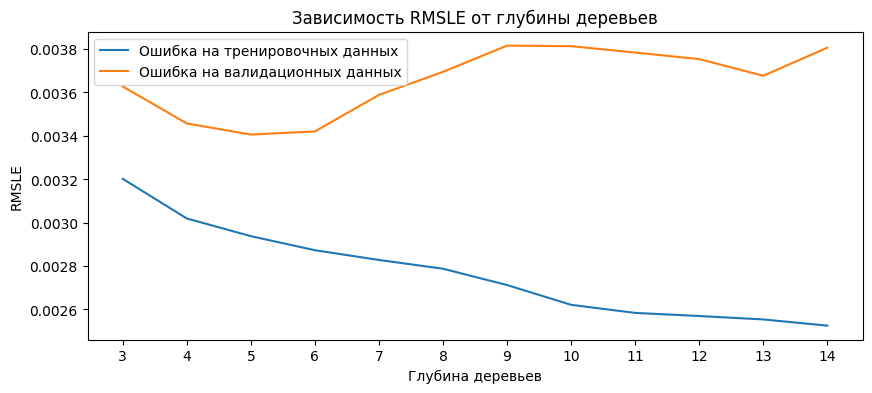

In [1675]:
#Визуализируем метрики
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(max_depths, rmse_train_md, label='Ошибка на тренировочных данных')
ax.plot(max_depths, rmse_valid_md, label='Ошибка на валидационных данных')
ax.set_title('Зависимость RMSLE от глубины деревьев')
ax.set_xlabel('Глубина деревьев')
ax.set_ylabel('RMSLE')
ax.legend()
ax.set_xticks(max_depths);

**Вывод**

Оптимальная глубина решающего дерева - 5

In [1680]:
dt_opt = DecisionTreeRegressor(random_state = RANDOM_STATE, max_depth=5)
dt_opt.fit(X_train_scaled, y_train)

y_train_pred_opt = dt_opt.predict(X_train_scaled)
y_valid_pred_opt = dt_opt.predict(X_valid_scaled)

rmse_tr_opt = round(np.sqrt(mean_squared_error(y_train, y_train_pred_opt)), 5)
rmse_vl_opt = round(np.sqrt(mean_squared_error(y_valid, y_valid_pred_opt)), 5)

print(f'Ошибка на тренировочных данных {rmse_tr_opt}')
print(f'Ошибка на валидационных данных {rmse_vl_opt}')

Ошибка на тренировочных данных 0.00294
Ошибка на валидационных данных 0.00341


Всё равно не удалось улучшить качество модели по сравнению с линейной регрессией, стоит попробовать ансамблирование

### Случайный лес

In [1683]:
rf = RandomForestRegressor(criterion='squared_error',
                n_estimators=200,
                max_depth=5,
                min_samples_split=20,
                random_state=RANDOM_STATE
)

rf.fit(X_train_scaled, y_train)

y_train_pred_rf = rf.predict(X_train_scaled)
y_valid_pred_rf = rf.predict(X_valid_scaled)

rmse_tr_rf = round(np.sqrt(mean_squared_error(y_train, y_train_pred_rf)), 5)
rmse_vl_rf = round(np.sqrt(mean_squared_error(y_valid, y_valid_pred_rf)), 5)
print(f'Ошибка на тренировочных данных {rmse_tr_rf}')
print(f'Ошибка на валидационных данных {rmse_vl_rf}')

Ошибка на тренировочных данных 0.0032
Ошибка на валидационных данных 0.00312


Загадка природы - ошибка на валидационной выборке меньше "тренирвочной" ошибки, нужно пробовать бустинг

## Градиентный бустинг над деревьями решений

In [1715]:
gb = GradientBoostingRegressor(learning_rate=0.5,
                n_estimators=100,
                max_depth=5, 
                min_samples_split=30,
                random_state=42,
                verbose=True
).fit(X_train_scaled, y_train)

y_train_pred_gb = gb.predict(X_train_scaled)
y_valid_pred_gb = gb.predict(X_valid_scaled)

rmse_tr_gb = round(np.sqrt(mean_squared_error(y_train, y_train_pred_gb)), 5)
rmse_vl_gb = round(np.sqrt(mean_squared_error(y_valid, y_valid_pred_gb)), 5)
print(f'Ошибка на тренировочных данных {rmse_tr_gb}')
print(f'Ошибка на валидационных данных {rmse_vl_gb}')

      Iter       Train Loss   Remaining Time 
         1           0.0000            0.11s
         2           0.0000            0.10s
         3           0.0000            0.11s
         4           0.0000            0.08s
         5           0.0000            0.08s
         6           0.0000            0.09s
         7           0.0000            0.09s
         8           0.0000            0.09s
         9           0.0000            0.08s
        10           0.0000            0.08s
        20           0.0000            0.06s
        30           0.0000            0.06s
        40           0.0000            0.05s
        50           0.0000            0.04s
        60           0.0000            0.03s
        70           0.0000            0.02s
        80           0.0000            0.02s
        90           0.0000            0.01s
       100           0.0000            0.00s
Ошибка на тренировочных данных 0.00251
Ошибка на валидационных данных 0.00357


Всё же лучший результат на валидационной выборке показал $Random Forest$, попробуем добавить ему качества, подобрав гиперпараметры

In [1711]:
params = {'n_estimators': list(range(20, 200, 10)),
              'min_samples_leaf': list(range(1, 10, 1)),
              'max_depth': list(np.linspace(5, 45, 5, dtype=int))
              }
            
rf_search = RandomizedSearchCV(
                                estimator=RandomForestRegressor(random_state=RANDOM_STATE), 
                                param_distributions=params, 
                                cv=7,
                                n_iter = 10, 
                                n_jobs = -1
).fit(X_train_scaled, y_train) 
best_par = rf_search.best_params_


y_train_pred_rfs = rf_search.predict(X_train_scaled)
y_valid_pred_rfs = rf_search.predict(X_valid_scaled)

rmse_tr_rfs = round(np.sqrt(mean_squared_error(y_train, y_train_pred_rfs)), 5)
rmse_vl_rfs = round(np.sqrt(mean_squared_error(y_valid, y_valid_pred_rfs)), 5)
print(f'Ошибка на тренировочных данных {rmse_tr_rfs}')
print(f'Ошибка на валидационных данных {rmse_vl_rfs}')
print("Наилучшие значения гиперпараметров: {}".format(best_par))

Ошибка на тренировочных данных 0.00318
Ошибка на валидационных данных 0.00299
Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': 2, 'max_depth': 5}


Метрику удалось улучшить существенно, хотя и остаётся загадкой превосходство валидационного качества над тренировочным

## Оценка значимости признаков

In [ ]:

rf_best = RandomForestRegressor(
    **best_par,
    random_state=RANDOM_STATE
).fit(X_train_scaled, y_train)

y_pred_rfb = rf_best.predict(X_valid_scaled)
rmse_vl_rfb = round(np.sqrt(mean_squared_error(y_valid, y_pred_rfb), 5))
print(f'Ошибка на валидационных данных {rmse_vl_rfb}')

In [1721]:
features = X_train_scaled.columns
feature_importances = rf_best.feature_importances_
imp = pd.DataFrame({'features': features, 'importances': feature_importances})
imp = imp.sort_values(by='importances', ascending=False).iloc[:14]


fig = px.bar(imp,
            x='features',
            y='importances'
)
fig.show();

**Вывод**

В рамках проекта удалось предобработать данные. обучить и оптимизировать модель,получить наиболее важные для целевой переменной признаки, таким образом на базе данного проекта может быть реализован сервис, определяющий какое влияние в процентном отношении оказывает тот или иной элемент рекламного объявления на рост кликабельности